In [ ]:
!pip install -q transformers datasets
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# from datasets import load_dataset
# ds = load_dataset("cifar10")

# train_ds = ds["train"]
# test_ds = ds["test"]

In [ ]:
from transformers import  BeitFeatureExtractor, BeitForImageClassification
from torchvision.transforms import ColorJitter
from torch.utils.data import Dataset
import os
from PIL import Image

# feature_extractor = BeitFeatureExtractor(do_resize=True, size=224, do_center_crop=False, do_reduce_label=True)
model = BeitForImageClassification.from_pretrained("jadohu/BEiT-finetuned")

# class ClassificationDataset(Dataset):
#     def __init__(self, data, feature_extractor):
#         self.data = data
#         self.feature_extractor = feature_extractor
#     def __len__(self):
#         return len(self.data)
#     def __getitem__(self, idx):
#         encoded_inputs = self.feature_extractor(self.data['img'][idx], return_tensors="pt")
#         labels = [0]*10
#         labels[self.data['label'][idx]] = 1
#         return encoded_inputs, torch.Tensor(labels)
# train_dataset = ClassificationDataset(train_ds, feature_extractor=feature_extractor)
# valid_dataset = ClassificationDataset(test_ds, feature_extractor=feature_extractor)

In [ ]:
model

BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (int

In [ ]:
sum(p.numel() for p in model.parameters())

85769674

In [ ]:
!pip install evaluate
import evaluate

metric = evaluate.load("mean_iou")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 6.8 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=16)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
Loss = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
Loss.to(device)

model.train()
for epoch in range(20): 
  print("Epoch:", epoch)
  Loss_total_train = list()
  
  for idx, data in enumerate(trainloader):
    inputs, labels = data
    pixel_values = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(pixel_values=pixel_values.squeeze(1))

    logits = outputs.logits
    loss = Loss(logits, labels)

    loss.backward()
    optimizer.step()

    Loss_total_train.append(loss.item())

  print("Loss:", sum(Loss_total_train)/len(Loss_total_train))

Epoch: 0
Loss: 0.12210169624007215
Epoch: 1
Loss: 0.06924458279106671
Epoch: 2
Loss: 0.054526276327364245
Epoch: 3
Loss: 0.043586955345203925
Epoch: 4
Loss: 0.04153632473106936
Epoch: 5
Loss: 0.03498824190842053
Epoch: 6


KeyboardInterrupt: ignored

In [ ]:
!pip install torchmetrics
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy, BinaryPrecision , BinaryRecall

metric1 = BinaryAccuracy()
metric2 = BinaryPrecision()

softmax = nn.Softmax(dim=1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 37.1 MB/s eta 0:00:00


In [ ]:
targets=[]
model_predicts=[]
losses=[]
model.eval() 
acc_list=[]
pre_list=[]
with torch.no_grad():
  for idx, data in enumerate(trainloader):
    inputs, labels = data
    
    x_tr = inputs.to(device)
    tar = labels.to(device)

    out=model(x_tr.squeeze(1))
    out = out.logits
    loss_t = Loss(out, tar)
    losses.append(loss_t.item())
    
    out = softmax(out)

    tars = torch.zeros(out.shape[0], 10)
    for i in range(out.shape[0]):
      tars[i][tar[i]] = 1.

    acc_list.append(metric1(out.cpu(), tars.cpu()))
    pre_list.append(metric2(out.cpu(), tars.cpu()))

    targets.extend((torch.max(tars, 1)[1]).data.cpu().numpy())
    model_predicts.extend((torch.max(out, 1)[1]).data.cpu().numpy())

  print(f'test loss : {sum(losses)/len(losses)}')
  print(f'Acc : {sum(acc_list)/len(acc_list)}')
  print(f'Pre : {sum(pre_list)/len(pre_list)}')

test loss : 0.01721311990815642
Acc : 0.9988044500350952
Pre : 0.9942799806594849


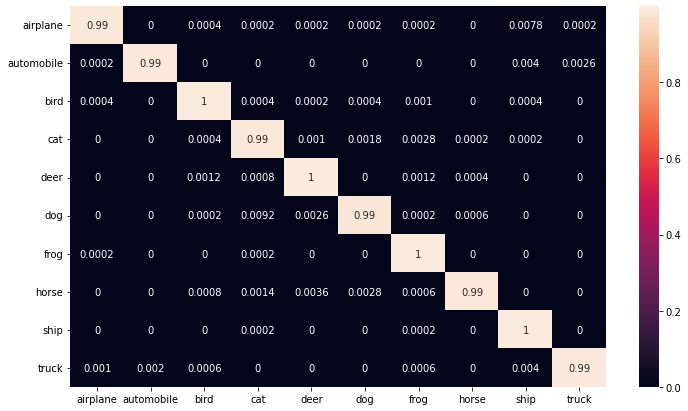

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
cf_matrix = confusion_matrix(targets, model_predicts)
classes=classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck')
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')